In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [2]:
df = pd.read_csv("dataset/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby("Category").describe()

Message                                                             
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later  \
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

## Downsampling for more accurate model because 4825/747 makes 0.15 percent 

In [4]:
df_ham_downsampled = df[df["Category"]=="ham"].sample(747)
df_ham_downsampled.shape

(747, 2)

In [5]:
df[df["Category"]=="spam"].shape

(747, 2)

In [6]:
df_balanced = pd.concat([df_ham_downsampled, df[df["Category"]=="spam"]])
df_balanced

,Category,Message
4811,ham,"Honey, can you pls find out how much they sell..."
3410,ham,Whats that coming over the hill..... Is it a m...
4820,ham,Got smaller capacity one? Quite ex...
2361,ham,Had the money issue weigh me down but thanks t...
2672,ham,"That's cool, I'll come by like &lt;#&gt; ish"
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [7]:
df_balanced["Category"].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [8]:
df_balanced.replace({"ham":0, "spam":1}, inplace=True)
df_balanced

,Category,Message
4811,0,"Honey, can you pls find out how much they sell..."
3410,0,Whats that coming over the hill..... Is it a m...
4820,0,Got smaller capacity one? Quite ex...
2361,0,Had the money issue weigh me down but thanks t...
2672,0,"That's cool, I'll come by like &lt;#&gt; ish"
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [9]:
df_balanced.rename({"Category": "Spam"}, axis=1, inplace=True)
df_balanced

,Spam,Message
4811,0,"Honey, can you pls find out how much they sell..."
3410,0,Whats that coming over the hill..... Is it a m...
4820,0,Got smaller capacity one? Quite ex...
2361,0,Had the money issue weigh me down but thanks t...
2672,0,"That's cool, I'll come by like &lt;#&gt; ish"
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced["Message"], df_balanced["Spam"],\
                                                    test_size=0.2, stratify=df_balanced["Spam"])

In [11]:
X_train.shape, X_test.shape

((1195,), (299,))

In [12]:
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

bert_preprocess = hub.KerasLayer(preprocessor_url)
bert_encoder = hub.KerasLayer(encoder_url)

In [13]:
# BERT Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
encoder_input = bert_preprocess(text_input)
outputs = bert_encoder(encoder_input)

# Neural Network Layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs["pooled_output"])
l = tf.keras.layers.Dense(1, activation="sigmoid", name = "output")(l)

# Counstruct Final Model

model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

!pip install pydot
!pip install graphviz

import pydot
import graphviz

import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

tf.keras.utils.plot_model(model, show_shapes=True)

plot_model(model, show_shapes=True, to_file='model.png')
img = plt.imread('model.png')
plt.imshow(img)
plt.show()

In [15]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name="accuracy"),
           tf.keras.metrics.Precision(name="precision"),
           tf.keras.metrics.Recall(name="recall")           
          ]


model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)

In [16]:
model.fit(X_train,y_train, epochs=10)

Epoch 1/10
38/38 [==============================] - 23s 342ms/step - loss: 0.6051 - accuracy: 0.7029 - precision: 0.7113 - recall: 0.6839
Epoch 2/10
38/38 [==============================] - 13s 342ms/step - loss: 0.4919 - accuracy: 0.8167 - precision: 0.7929 - recall: 0.8579
Epoch 3/10
38/38 [==============================] - 13s 339ms/step - loss: 0.4206 - accuracy: 0.8644 - precision: 0.8516 - recall: 0.8829
Epoch 4/10
38/38 [==============================] - 13s 339ms/step - loss: 0.3730 - accuracy: 0.8837 - precision: 0.8708 - recall: 0.9013
Epoch 5/10
38/38 [==============================] - 13s 339ms/step - loss: 0.3441 - accuracy: 0.8979 - precision: 0.8839 - recall: 0.9164
Epoch 6/10
38/38 [==============================] - 13s 341ms/step - loss: 0.3233 - accuracy: 0.8887 - precision: 0.8685 - recall: 0.9164
Epoch 7/10
38/38 [==============================] - 13s 341ms/step - loss: 0.3052 - accuracy: 0.8987 - precision: 0.8841 - recall: 0.9181
Epoch 8/10
38/38 [================

In [17]:
y_predicted = model.predict(X_test)
y_predicted.shape

10/10 [==============================] - 4s 334ms/step


(299, 1)

In [18]:
y_pred = [1 if x > 0.5 else 0 for x in y_predicted]

In [19]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       150
           1       0.90      0.90      0.90       149

    accuracy                           0.90       299
   macro avg       0.90      0.90      0.90       299
weighted avg       0.90      0.90      0.90       299



Text(50.722222222222214, 0.5, 'Truth')

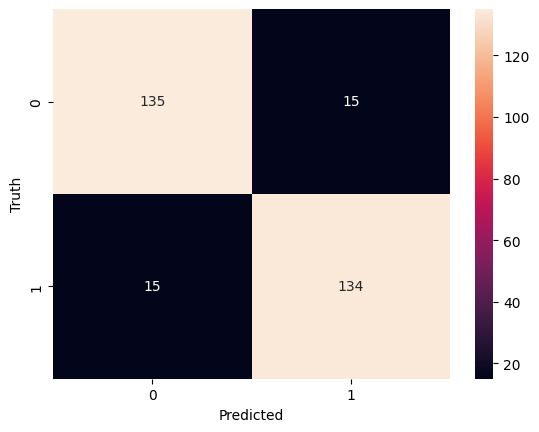

In [20]:
import matplotlib.pyplot as plt
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

# plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [21]:
reviews = [
    "Enter to win 5000$ dollar. This is the last chance Runnn.",
    "Hi what are you doing tomorrow? I miss you...",
    "Not a SPAM. This is auto message, do not reply. Your subscription is ending.",
    "I need money. pls sen this addres BTC, TRX B4t5d8fd4w2d45586d154d",
    "You won prize  . call 87546875768 for take it. hurryy uppp. limited offer"
]
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.3442374 ],
       [0.05222135],
       [0.38877186],
       [0.15439585],
       [0.2534116 ]], dtype=float32)

In [23]:
model.save("saved_model/1")

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets
